## 1. Importing the necessary libraries.

In [1]:
import polars as pl
import polars.selectors as sc
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

import pathlib as path

# 2. Reading the data from Excel sheets.

In [ ]:
expenses_df: pl.DataFrame = pl.read_excel("Expenses.xlsx", 
                                       sheet_name = "Expenses",
                                       has_header = True)

income_df:pl.DataFrame = pl.read_excel("Incomes.xlsx", 
                                       sheet_name = "Incomes",
                                       has_header = True)


Income date,Income amount,Income category
date,f64,str
2024-02-04,60.0,"""Private tutoring salary"""
2024-02-08,400.0,"""Transfer from parents"""
2024-02-11,70.0,"""Private tutoring salary"""
2024-02-17,50.0,"""Transfer from parents"""
2024-02-19,100.0,"""Transfer from parents"""
…,…,…
2025-02-13,100.0,"""Transfer from grandparents"""
2025-02-14,1075.0,"""Transfer from parents"""
2025-02-15,200.0,"""Transfer from grandparents"""


# 3. Grouping the costs by month and year.

In [3]:
grouped_cost: pl.DataFrame = (   expenses_df.group_by(pl.col("Expense date").dt.year().alias("Year"),
                                                   pl.col("Expense date").dt.quarter().alias("Quarter"),
                                                   pl.col("Expense date").dt.strftime("%b").alias("Month"),
                                                   maintain_order = True).
                                                   agg(pl.col("Expense cost").sum().alias("Total expenses")) )


grouped_income:pl.DataFrame = ( income_df.group_by( pl.col("Income date").dt.year().alias("Year"),
                                                 pl.col("Income date").dt.quarter().alias("Quarter"), 
                                                 pl.col("Income date").dt.strftime("%b").alias("Month"), 
                                                 maintain_order = True).
                                                agg(pl.col("Income amount").sum().alias("Total income")) )


## 4. Preprocessing the balance sheet for plotting.

In [4]:
# Join the grouped_income with grouped_cost.
balances:pl.DataFrame    = grouped_income.join(grouped_cost, on = (pl.col("Year"), pl.col("Month")),
                                                    how = "full").select(~sc.ends_with("right")).fill_null(0)


# Add a column "Miesięczne saldo"
balances:pl.DataFrame = balances.with_columns( (pl.col("Total income") - pl.col("Total expenses")).alias("Monthly balance"))


# Convert the balance sheet to long form.
balances_long:pl.DataFrame = balances.unpivot(index = ("Year","Quarter", "Month"),
                                                              variable_name = "Financial category",
                                                             value_name = "Amount")

fin_cat:pl.Expr = pl.col("Financial category")


hue_variable: pl.Expr = ( pl.when( fin_cat.is_in( ["Total income", "Total expenses"])).
                         then(
                             fin_cat
                             ).otherwise( 
                                 pl.when(pl.col("Amount") >=0).
                                 then(pl.lit("Positive balance")).
                                 otherwise(pl.lit("Negative balance"))
                             ).alias("Financial category") 
                             )

balances_long: pl.DataFrame = balances_long.with_columns(hue_variable)

balances_long


Year,Quarter,Month,Financial category,Amount
i32,i8,str,str,f64
2024,1,"""Feb""","""Total income""",1468.0
2024,1,"""Mar""","""Total income""",1070.0
2024,2,"""Apr""","""Total income""",1606.5
2024,2,"""May""","""Total income""",1630.0
2024,2,"""Jun""","""Total income""",1928.0
…,…,…,…,…
2024,4,"""Oct""","""Positive balance""",448.86
2024,4,"""Nov""","""Positive balance""",515.225
2024,4,"""Dec""","""Positive balance""",2380.78


## 5. Visualizing the annual general balance sheets.

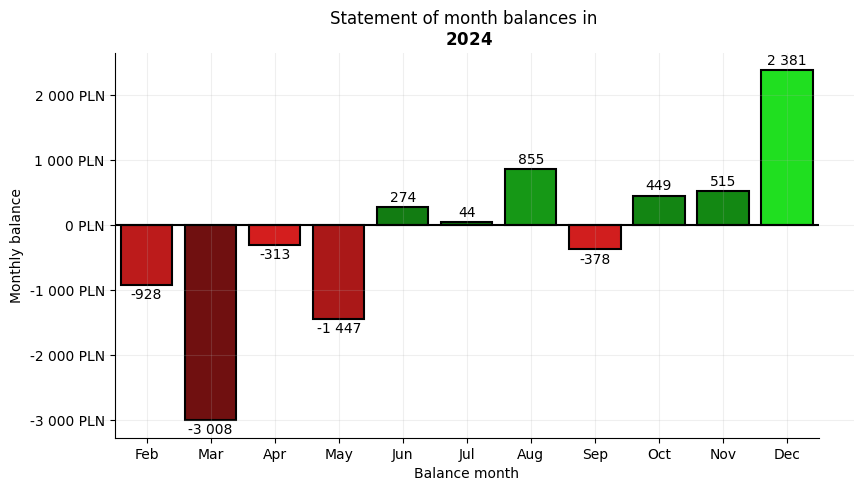

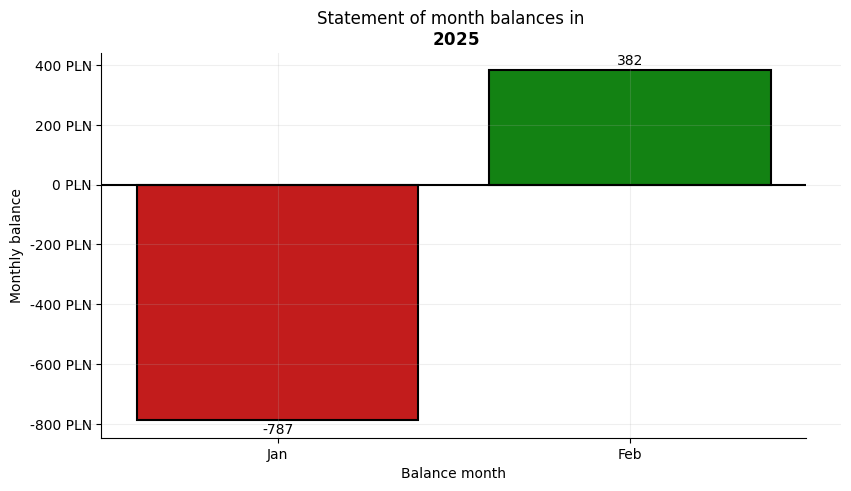

In [5]:
monthly_balances:pd.DataFrame = balances_long.filter(pl.col("Financial category").str.ends_with("balance"))

monthly_general_balances_path: path.Path = path.Path().cwd()/r"General monthly balances"


# Create a Normalizer for our data for the color map to work properly.
Normalize = colors.Normalize(monthly_balances["Amount"].min(), monthly_balances["Amount"].max())

# Find the "turning" normalized value (that is, if Normalize(x) < x0 then x is negative, otherwise - positive)
x0 = Normalize(0)

# Define the color entries for the LinearSegmentedColorMap.
red : list[tuple[int]] = [(0, 0, 0.5), (x0, 1, 0), (1, 0, 0)]
green : list[tuple[int]] = [(0, 0, 0), (x0, 0 ,0.5), (1, 1, 1)]
blue : list[tuple[int]] =  [(0, 0, 0), (1, 0, 0)]
alpha: list[tuple[int]] = [(0, 1, 1), (x0, 0, 0), (1, 1,1)]



# Let's create a custom color map
financial_colormap = colors.LinearSegmentedColormap("FinancialPalette", 
                                            {"red": red, "green": green, "blue": blue,
                                            "alpha": alpha})



def generate_month_balance_sheet(year:int) -> None:
    """The function generates the month balance sheet plot for a given year. All of the plots are saved in a given path.
    
    Parameters:
    ---------
    year: int
        The year of the month balances.

    Returns:
    None

    """
    # Filter the balance sheet by year.
    df_filtered = monthly_balances.filter(pl.col("Year") == year)


    # Convert the values to color.
    kolory = [financial_colormap(Normalize(v)) for v in df_filtered["Amount"]] 


    # Create a figure
    figure = plt.figure(figsize=(10, 5))
    axes = sns.barplot(data=df_filtered, x="Month", y="Amount", 
                       palette=kolory, hue = "Month", 
                       legend = False,
                       edgecolor = "black", linewidth = 1.5)


    xlim: tuple[float] = axes.get_xlim()

    # Customizing the plot.
    axes.spines[["top", "right"]].set_visible(False)
    axes.grid(True, alpha = 0.2)

    # Setting the title of the plot and axis labels.
    axes.set_title("Statement of month balances in \n"+ rf"$\bf{{\ {year}}}$")
    axes.set_ylabel("Monthly balance")
    axes.set_xlabel("Balance month")

    # Adjust the  bounds of the bottom spine
    xlim: tuple[float] = axes.get_xlim()

    # Rebounding the bottom spine.
    axes.spines["bottom"].set_bounds(xlim[0], xlim[1])
    
    # Set the position of the left spine.
    axes.spines["left"].set_position(("data",xlim[0]))

    # Add a new Ox axis at position y =0.
    axes.hlines(0, xlim[0], xlim[1], colors = "black")
    
    # Set the major formatter for the yaxis.
    axes.yaxis.set_major_formatter(lambda x,v: f"{x:,.0f} PLN".replace(",", " "))

    
    for container in axes.containers:
        axes.bar_label(container, fmt = lambda v: f"{v:,.0f}".replace(",", " "), padding = 2)


    if not monthly_general_balances_path.exists():
        monthly_general_balances_path.mkdir()
    
    figure.savefig(fname = monthly_general_balances_path/rf"Month financial balances for the year {year}")

# Generate the month balance sheets for each year available in the dataset.
for year in monthly_balances["Year"].unique():
    generate_month_balance_sheet(year)



# 7. Visualizing the income and expenses for each month.

### For a given year, we group the income and expenses by quarter and visualize these groups on a single plot.

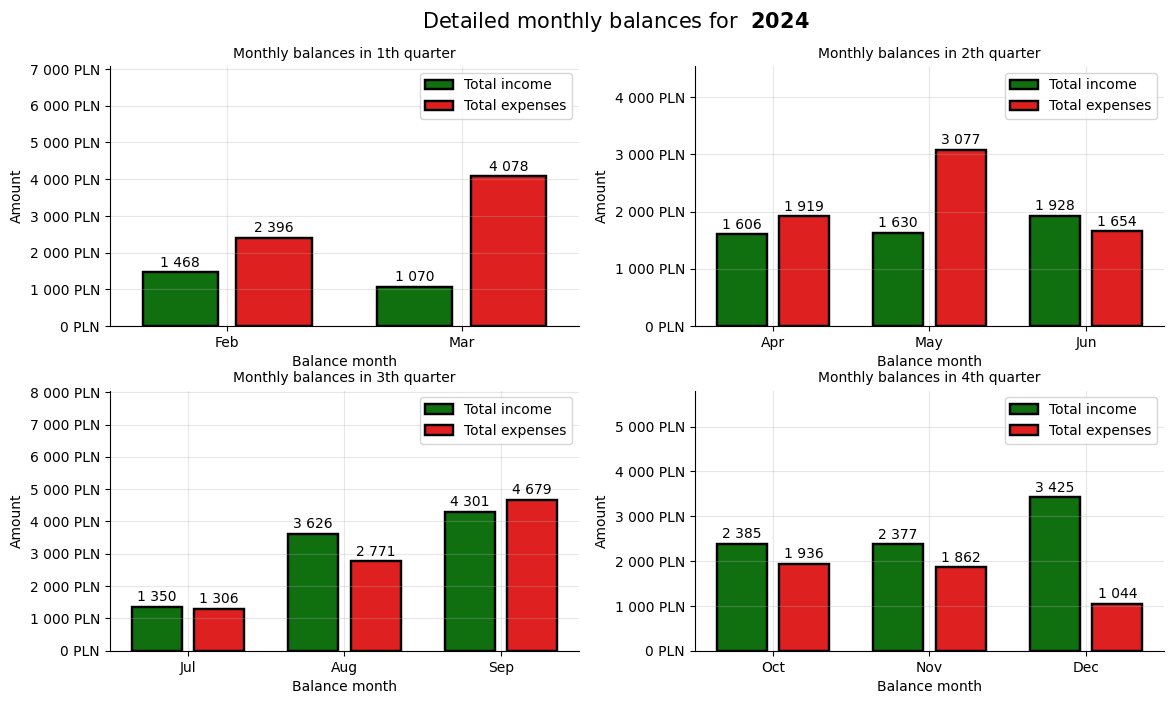

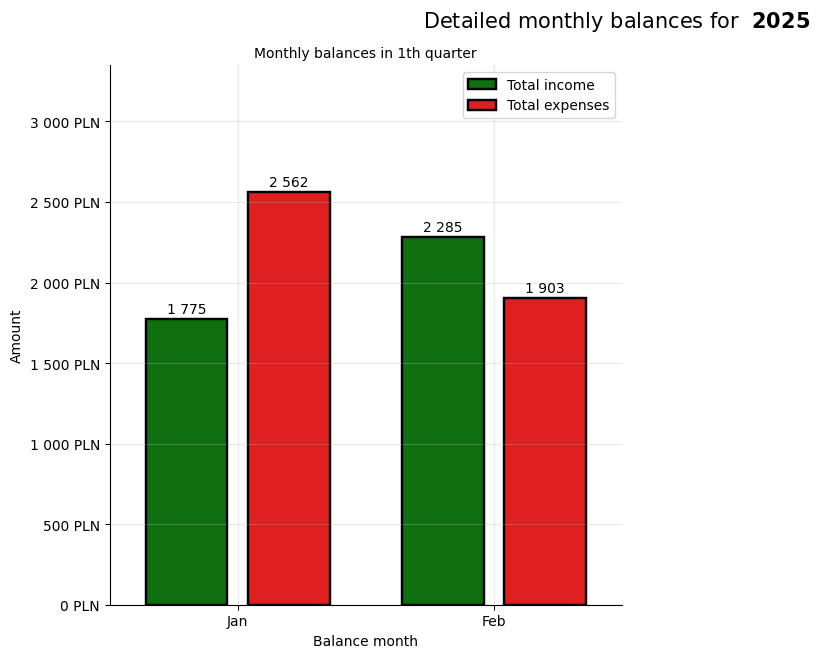

In [6]:
year: int = 2024

monthly_detailed_balances_path: path.Path = path.Path().cwd()/r"Detailed monthly balances"


def generate_month_detailed_balances(year:int) -> None:
    # Filter the balance sheets and add a new column for "signed" amount.
    year_balance_sheets: pl.DataFrame = ( balances_long.
                                        filter(pl.col("Year") == year, 
                                                pl.col("Financial category").str.starts_with("Total"))
                                                
                                                )


    FacetGrid = sns.FacetGrid(data = year_balance_sheets, col = "Quarter", col_wrap = 2, sharex = False, sharey = False)
    # Set title for each subplot.
    FacetGrid.set_titles(template = "Monthly balances in {col_name}th quarter")
    # Set the global title for the whole figure.

    FacetGrid.fig.suptitle(fr"Detailed monthly balances for  $\bf{{{year}}}$",
                           size = 15)
    
    FacetGrid.fig.subplots_adjust(top=0.9)  # Zwiększ wartość top, aby podwyższyć tytuł



    for quarter_id, axes in FacetGrid.axes_dict.items():
        # Find the rows from a given quarter.
        quarter_balance_sheets: pl.DataFrame = year_balance_sheets.filter(pl.col("Quarter") == quarter_id)

        sns.barplot(quarter_balance_sheets, x = "Month", y = "Amount", hue = "Financial category",
                    ax = axes,
                    palette = {"Total expenses":"red", "Total income":"green"},
                    edgecolor = "black",
                    linewidth = 1.75
                    )

        # Find the minimum and maximum amount respectively.
        y_min, y_max = quarter_balance_sheets["Amount"].min(), quarter_balance_sheets["Amount"].max()

        legend = axes.get_legend()
        axes.get_legend().set_title("")

        axes.set_xlabel("Balance month")

        axes.set_ylim(0, y_max*(  1.0+(y_max-y_min)/y_max))
        axes.yaxis.set_major_formatter(lambda x,v: f"{x:,.0f} PLN".replace(",", " "))

        axes.grid(True, alpha = 0.3)

        # Add bar labels.
        for i in range(len(axes.containers)):
            axes.bar_label(axes.containers[i], fmt = lambda v: f"{v:,.0f}".replace(",", " "),
                           padding = 2)
        
        # Resize the width of the bars so that the bar labels wouldn't overlap.
        q: float = 0.8
        for patch in axes.patches:
           current_width: float = patch.get_width()

           patch.set_width(w = current_width*q)
           patch.set_x( patch.get_x() +  current_width/2 *(1-q))
        
    # Get the figure.
    figure: plt.Figure = axes.get_figure()
    
    # Change the shapes of the figure.
    figure.set_size_inches((12, 7))

    
    if not monthly_detailed_balances_path.exists():
        monthly_detailed_balances_path.mkdir()
    
    figure.savefig(monthly_detailed_balances_path/rf"Month financial balances for the year {year}")




for year in balances_long["Year"].unique():
    generate_month_detailed_balances(year)  

# 8. Visualizing the share of expense categories in monthly spendings.

In [ ]:

cat_monthly_expense_share: pl.DataFrame = expenses_df.group_by(pl.col("Expense date").dt.year().alias("Year"),
                                                        pl.col("Expense date").dt.month().alias("Month"), 
                                                       pl.col("KategoriaZakupu").alias("Expense category"),
                                                       maintain_order = True
                                                       ).agg(pl.sum("Cena").alias("Total amount"))

month: str = "Feb"
year:int = 2025


# Filter out the monthly expenses and add a normalized amount of the expenses. 
cat_monthly_share_filtered:pl.DataFrame = ( cat_monthly_expense_share.filter(pl.col("Year")== year,pl.col("Month") == month).
with_columns((100*pl.col("Total amount")/pl.sum("Total amount")).alias('Expense share')).drop("Year", "Month")
)




# Group the least-expensive categories.
grouping_condition: pl.Expr = ( pl.when(pl.col("Expense share") <=1)
.then(pl.lit("Inne"))
.otherwise(pl.col("Expense category")).
alias("Expense category") )

cat_monthly_share_filtered : pl.DataFrame = ( cat_monthly_share_filtered.with_columns(grouping_condition )
.group_by(pl.col("Expense category"), maintain_order = True).
agg(pl.sum("Total amount"), pl.sum("Expense share")) )


fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

fig.set_size_inches(12, 8)
wedges, labels = plt.pie(cat_monthly_share_filtered["Expense share"], labels = cat_monthly_share_filtered["Expense category"],
        wedgeprops = {"edgecolor":"black", "linewidth":1.5},
        )



import numpy as np
label = labels[0]
wedge = wedges[0]


slope = np.tan(    np.deg2rad((wedge.theta1+wedge.theta2)/2)    )
x = np.arange(label.get_position()[0],0, 0.01)
y = slope *x

ax.plot(x,y, color = "black")

NameError: name 'year_col' is not defined